In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from accelerate import Accelerator
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from IPython.display import clear_output
from tqdm.auto import tqdm
from time import time
from typing import Tuple
import sys

In [2]:
class CONFIG:

    USE_MIXED_PRECISION = "fp16"
    DOWNSCALE = 2
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    EXTRA_LOSS_EPS = 1e-6
    BATCH_SIZE = 8
    SINGLE_NETWORK_TRAINING_EPOCHS = 15
    CE_VS_DICE_EVAL_EPOCHS = 15
    DELTA_BETA = 0.2

cfg = CONFIG()

In [3]:
datapath = os.path.join("/content/drive/MyDrive", "cityscapes_data")

train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]


print(f"size of training : {len(training_images_paths)}")
print(f"size of validation : {len(validation_images_paths)}")

size of training : 2975
size of validation : 500


In [4]:
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

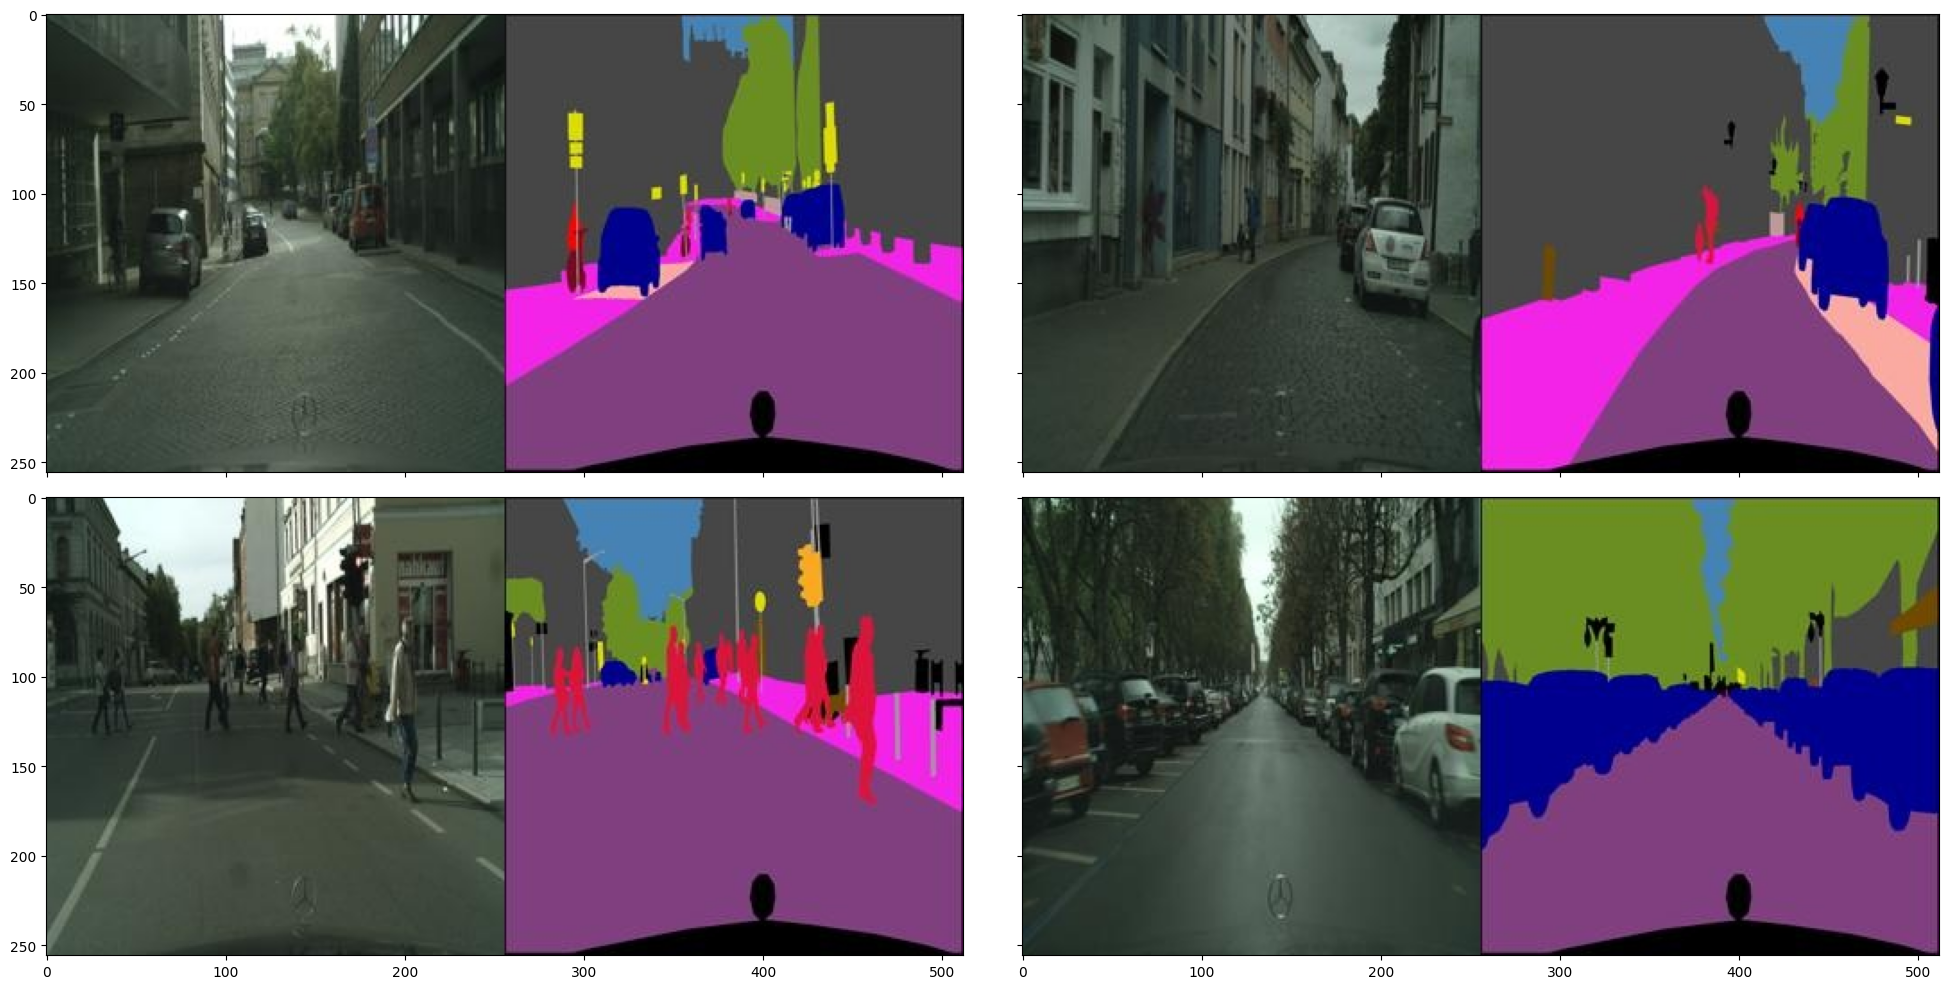

In [5]:
width = 2
height = 2
vis_batch_size = width * height
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]


fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(20, 10))
for i in range(vis_batch_size):

    img = torchvision.io.read_image(training_images_paths[indexes[i]])
    img = img.permute(1, 2, 0)
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())

plt.tight_layout()

In [6]:
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road',
               'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole',
               'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car',
               'truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']

idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}


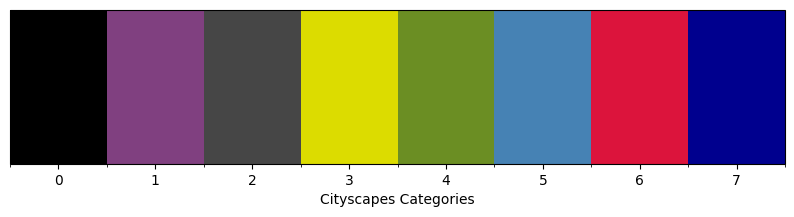

In [7]:
category_colors = [
    [0, 0, 0],        # void (black)
    [128, 64, 128],   # flat (purple)
    [70, 70, 70],     # construction (dark gray)
    [220, 220, 0],    # object (yellow)
    [107, 142, 35],   # nature (green)
    [70, 130, 180],   # sky (blue)
    [220, 20, 60],    # human (red)
    [0, 0, 142]       # vehicle (dark blue)
]
category_colors_norm = np.array(category_colors) / 255.0
category_cmap = mcolors.ListedColormap(category_colors_norm, name="Cityscapes_Categories")
bounds = np.arange(len(idx_to_category) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, category_cmap.N)
fig, ax = plt.subplots(figsize=(10, 2))
cb = plt.colorbar(
    plt.cm.ScalarMappable(cmap=category_cmap, norm=norm),
    cax=ax, orientation="horizontal", ticks=np.arange(len(idx_to_category))
)
cb.set_label("Cityscapes Categories")

In [8]:
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """

    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor
        img = img.resize(( width, height ))

    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]

    height, width, channels = mask.shape
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)

    return raw, mask, classes

In [9]:
train_images_to_use = -1
downscale_factor=cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y

In [11]:
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])


train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)


torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])


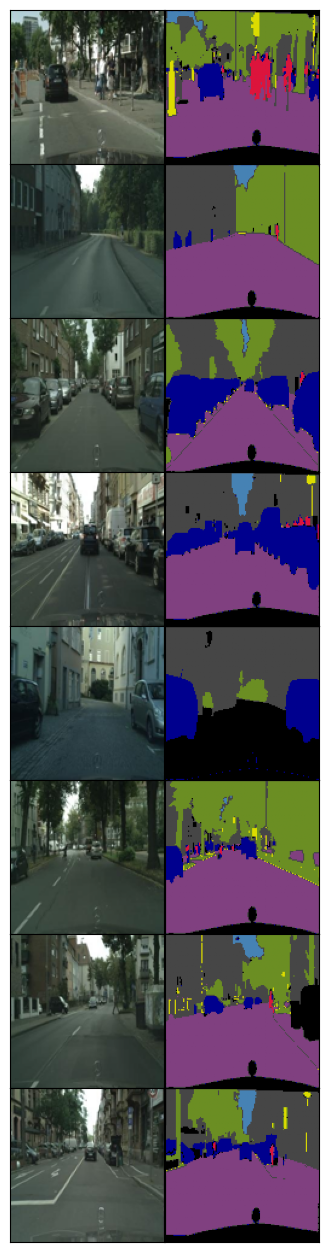

In [12]:
eval_batch_data = next(iter(val_dataloader))
def decode_image(img : torch.Tensor) -> torch.Tensor:
    return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

print(eval_batch_data[0].shape, eval_batch_data[1].shape)
batch_size = eval_batch_data[0].shape[0]
fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(batch_size):
    img, mask = eval_batch_data[0][i], eval_batch_data[1][i]
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])

    axes[i, 1].imshow(mask, cmap=category_cmap)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

In [13]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    dice = (inter + eps) / (sets_sum + eps)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    inter = (inp * tgt).sum(dim=sum_dim)
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

In [14]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice=True, with_iou=True):
    val_loss = 0
    val_dice = 0
    val_iou = 0
    examples_so_far = 0

    model.eval()
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} - Validation Loss: 0") as pbar:
        for batch in val_dataloader:
            images, true_masks = batch[0].to(device), batch[1].to(device).long()

            with torch.no_grad():
                masks_pred = model(images)

            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item()
            examples_so_far += 1

            num_classes = masks_pred.shape[1]
            true_masks_onehot = F.one_hot(true_masks, num_classes).permute(0, 3, 1, 2).float()

            dice = dice_loss(F.softmax(masks_pred, dim=1), true_masks_onehot)

            if with_dice:
                loss += dice
            val_dice += (1. - dice.item())

            iou = IoU_loss(F.softmax(masks_pred, dim=1), true_masks_onehot)

            if with_iou:
                loss += iou
            val_iou += (1. - iou.item())

            pbar.update(1)
            pbar.set_description(f"Epoch {epoch}/{epochs} - Validation Loss: {val_loss / examples_so_far:.3f}, IoU: {val_iou / examples_so_far:.3f}, Dice: {val_dice / examples_so_far:.3f}")

    return {
        "validation_loss": val_loss / examples_so_far,
        "validation_DICE_score": val_dice / examples_so_far,
        "validation_IoU_score": val_iou / examples_so_far,
    }


def train_model(model, device, train_dataloader, val_dataloader, epochs=10, lr=1e-4, with_dice=True, with_iou=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    results = []

    for epoch in range(1, epochs + 1):
        train_loss = 0
        train_dice = 0
        train_iou = 0
        examples_so_far = 0

        model.train()
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} - Training Loss: 0") as pbar:
            for batch in train_dataloader:
                optimizer.zero_grad()
                images, true_masks = batch[0].to(device), batch[1].to(device).long()

                masks_pred = model(images)
                loss = criterion(masks_pred, true_masks)

                num_classes = masks_pred.shape[1]
                true_masks_onehot = F.one_hot(true_masks, num_classes).permute(0, 3, 1, 2).float()

                if with_dice:
                    dice = dice_loss(F.softmax(masks_pred, dim=1), true_masks_onehot)
                    loss += dice
                    train_dice += (1. - dice.item())

                if with_iou:
                    iou = IoU_loss(F.softmax(masks_pred, dim=1), true_masks_onehot)
                    loss += iou
                    train_iou += (1. - iou.item())

                accelerator.backward(loss)
                optimizer.step()

                train_loss += loss.item()
                examples_so_far += 1

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch}/{epochs} - Training Loss: {train_loss / examples_so_far:.3f}")

        epoch_result = {
            "training_loss": train_loss / examples_so_far,
            "training_DICE_score": train_dice / examples_so_far if with_dice else None,
            "training_IoU_score": train_iou / examples_so_far if with_iou else None,
        }

        val_result = evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice, with_iou)
        epoch_result.update(val_result)
        results.append(epoch_result)

    return results

In [15]:
def plot_training_progress(results, save_path=None):

    epochs = range(1, len(results) + 1)
    train_loss = [res["training_loss"] for res in results]
    val_loss = [res["validation_loss"] for res in results]

    train_dice = [res.get("training_DICE_score", None) for res in results]
    val_dice = [res["validation_DICE_score"] for res in results]

    train_iou = [res.get("training_IoU_score", None) for res in results]
    val_iou = [res["validation_IoU_score"] for res in results]

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss", marker="o", linestyle="-", color="red")
    plt.plot(epochs, val_loss, label="Validation Loss", marker="o", linestyle="--", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dice, label="Train Dice", marker="o", linestyle="-", color="green")
    plt.plot(epochs, val_dice, label="Validation Dice", marker="o", linestyle="--", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score")
    plt.title("Training vs Validation Dice Score")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_iou, label="Train IoU", marker="o", linestyle="-", color="orange")
    plt.plot(epochs, val_iou, label="Validation IoU", marker="o", linestyle="--", color="cyan")
    plt.xlabel("Epochs")
    plt.ylabel("IoU Score")
    plt.title("Training vs Validation IoU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

In [16]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap=category_cmap)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap=category_cmap)
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")


##Unet

In [34]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])


        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=16, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)

        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)

        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [40]:
number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [8, 8, 128, 128]          --
├─ConvBlock: 1-1                         [8, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 16, 128, 128]         432
│    └─BatchNorm2d: 2-2                  [8, 16, 128, 128]         32
│    └─ReLU: 2-3                         [8, 16, 128, 128]         --
│    └─Conv2d: 2-4                       [8, 16, 128, 128]         2,304
│    └─BatchNorm2d: 2-5                  [8, 16, 128, 128]         32
│    └─ReLU: 2-6                         [8, 16, 128, 128]         --
├─DownScale: 1-2                         [8, 32, 64, 64]           --
│    └─MaxPool2d: 2-7                    [8, 16, 64, 64]           --
│    └─ConvBlock: 2-8                    [8, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [8, 32, 64, 64]           4,608
│    │    └─BatchNorm2d: 3-2             [8, 32, 64, 64]           64
│    │  

In [47]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)
Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS,with_dice=True, with_iou=True)

Epoch 1/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 1/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 2/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 3/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 4/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 5/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 6/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 7/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 8/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 9/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 10/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 11/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 12/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 13/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 14/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 15/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

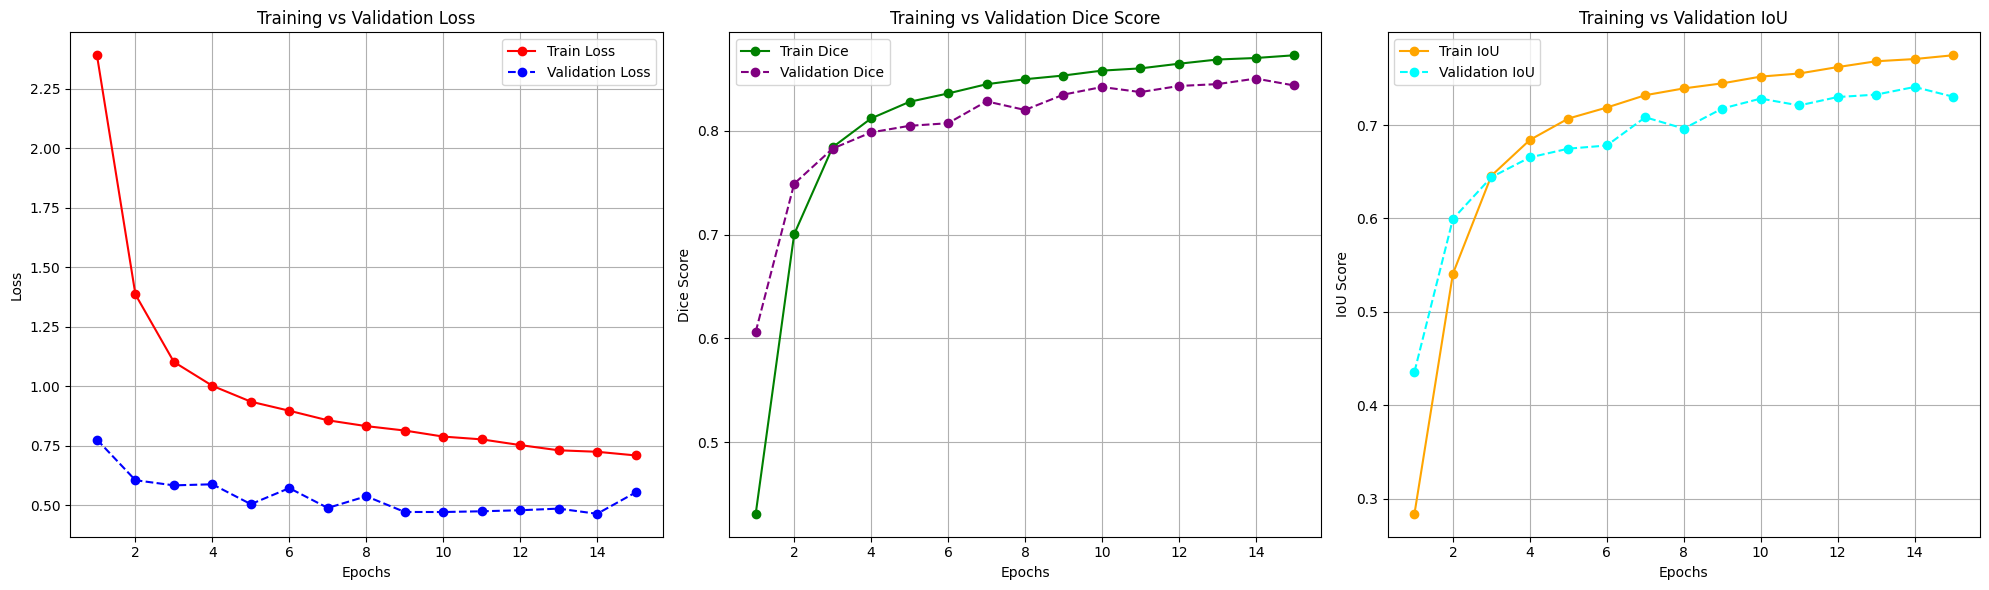

In [48]:
plot_training_progress(Unet_training_val_summary)

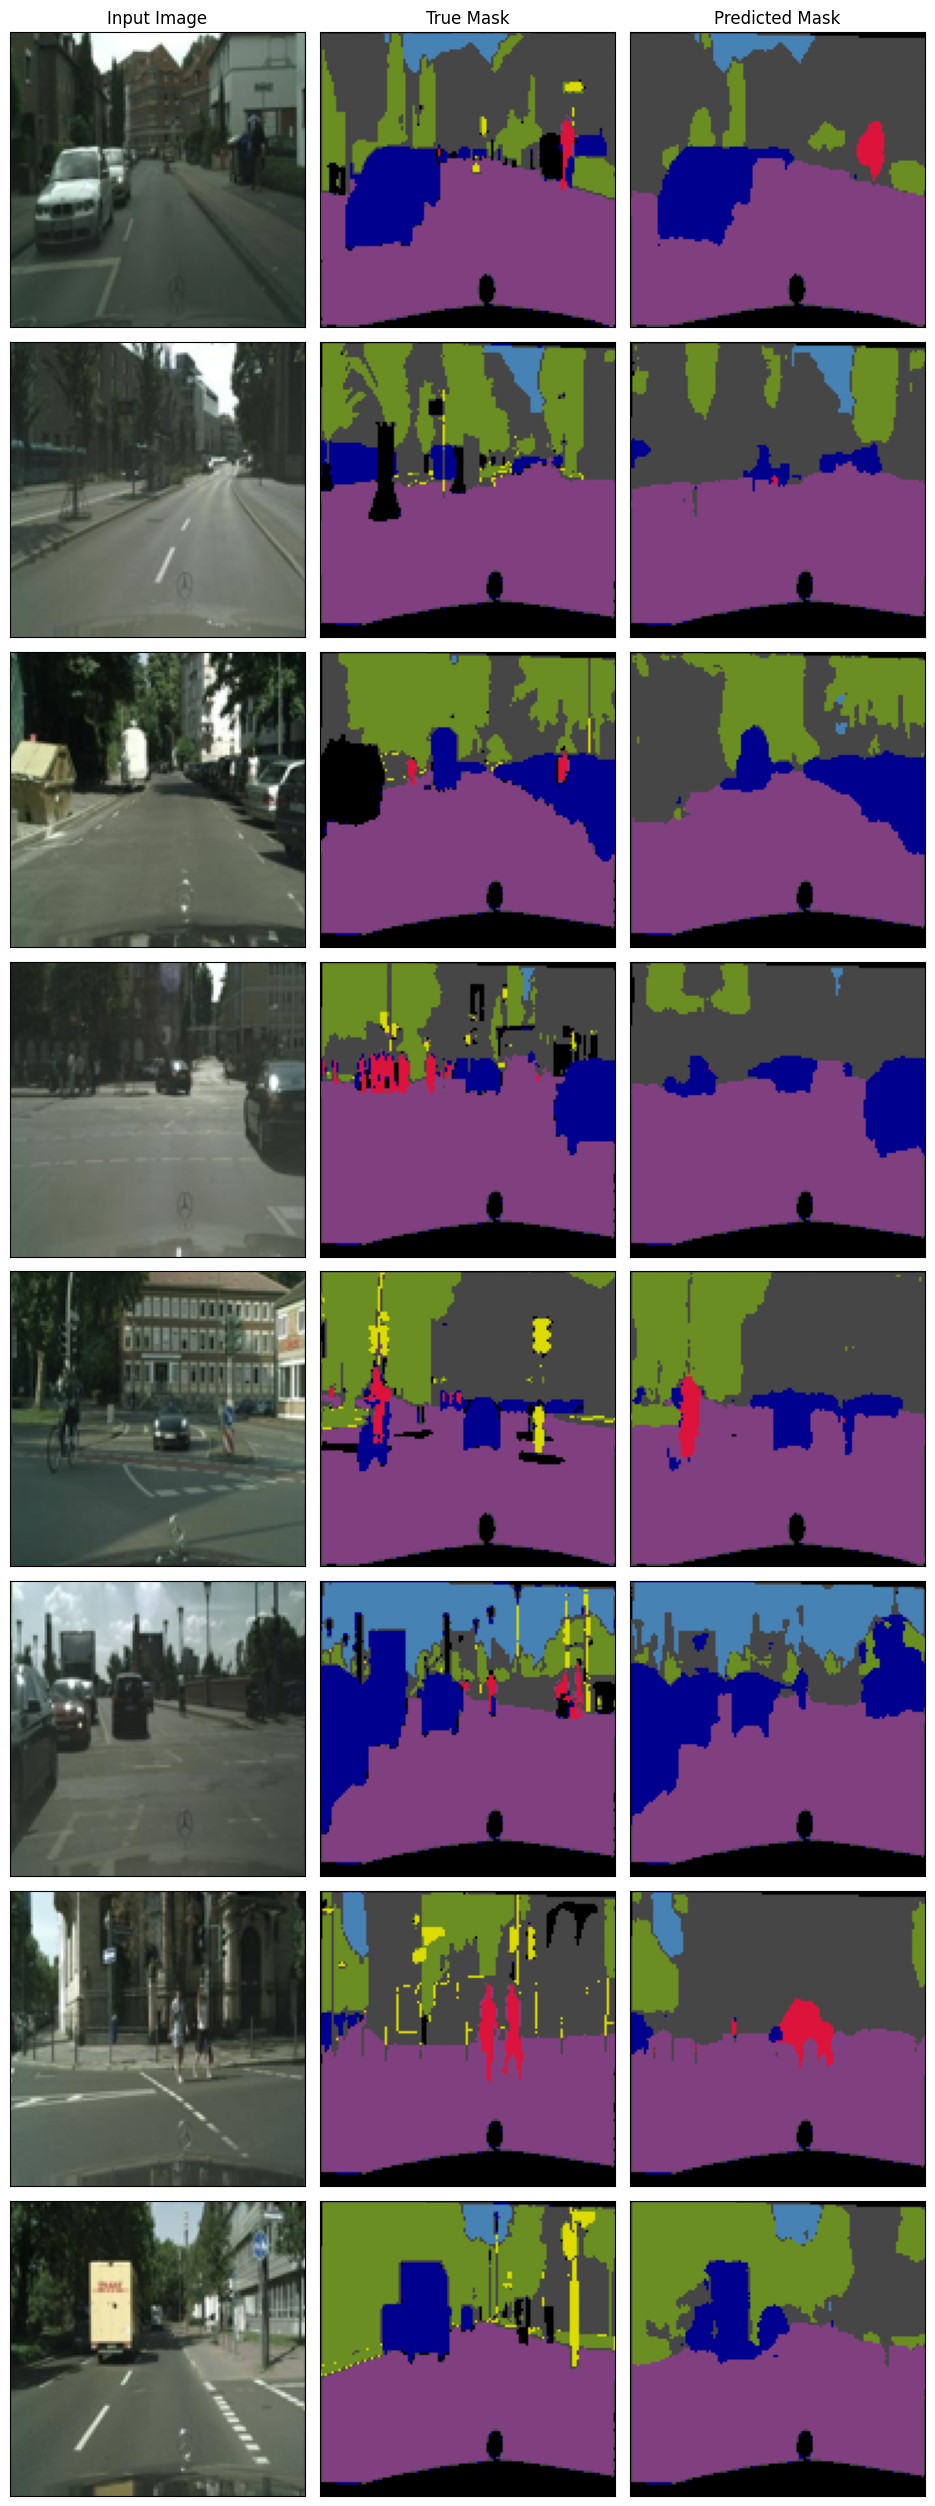

In [49]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

##Nested Unet

In [39]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [156]:
class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [16, 32, 64, 128, 256]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [158]:
summary(NestedUNet(number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                   Output Shape              Param #
NestedUNet                               [8, 8, 128, 128]          --
├─VGGBlock: 1-1                          [8, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 16, 128, 128]         448
│    └─BatchNorm2d: 2-2                  [8, 16, 128, 128]         32
│    └─ReLU: 2-3                         [8, 16, 128, 128]         --
│    └─Conv2d: 2-4                       [8, 16, 128, 128]         2,320
│    └─BatchNorm2d: 2-5                  [8, 16, 128, 128]         32
│    └─ReLU: 2-6                         [8, 16, 128, 128]         --
├─MaxPool2d: 1-2                         [8, 16, 64, 64]           --
├─VGGBlock: 1-3                          [8, 32, 64, 64]           --
│    └─Conv2d: 2-7                       [8, 32, 64, 64]           4,640
│    └─BatchNorm2d: 2-8                  [8, 32, 64, 64]           64
│    └─ReLU: 2-9                         [8, 32, 64, 64]           --
│    └─C

In [164]:
model_nested = NestedUNet(number_of_classes)
model_nested = model_nested.to(device)
nested_Unet_training_val_summary = train_model(model_nested, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS,with_dice=True, with_iou=True)


Epoch 1/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 1/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 2/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 3/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 4/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 5/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 6/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 7/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 8/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 9/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 10/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 11/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 12/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 13/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 14/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/15 - Training Loss: 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 15/15 - Validation Loss: 0:   0%|          | 0/63 [00:00<?, ?it/s]

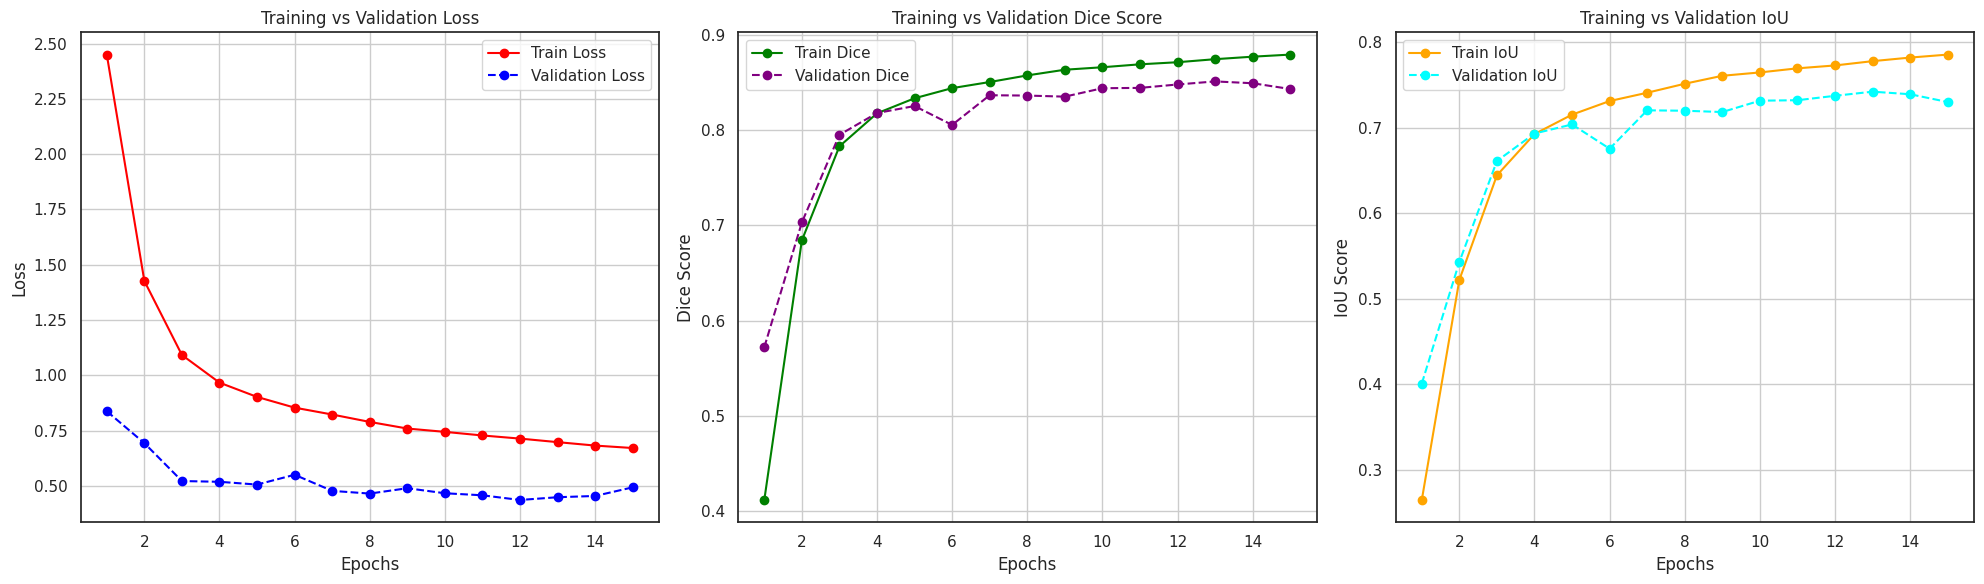

In [165]:
plot_training_progress(nested_Unet_training_val_summary)

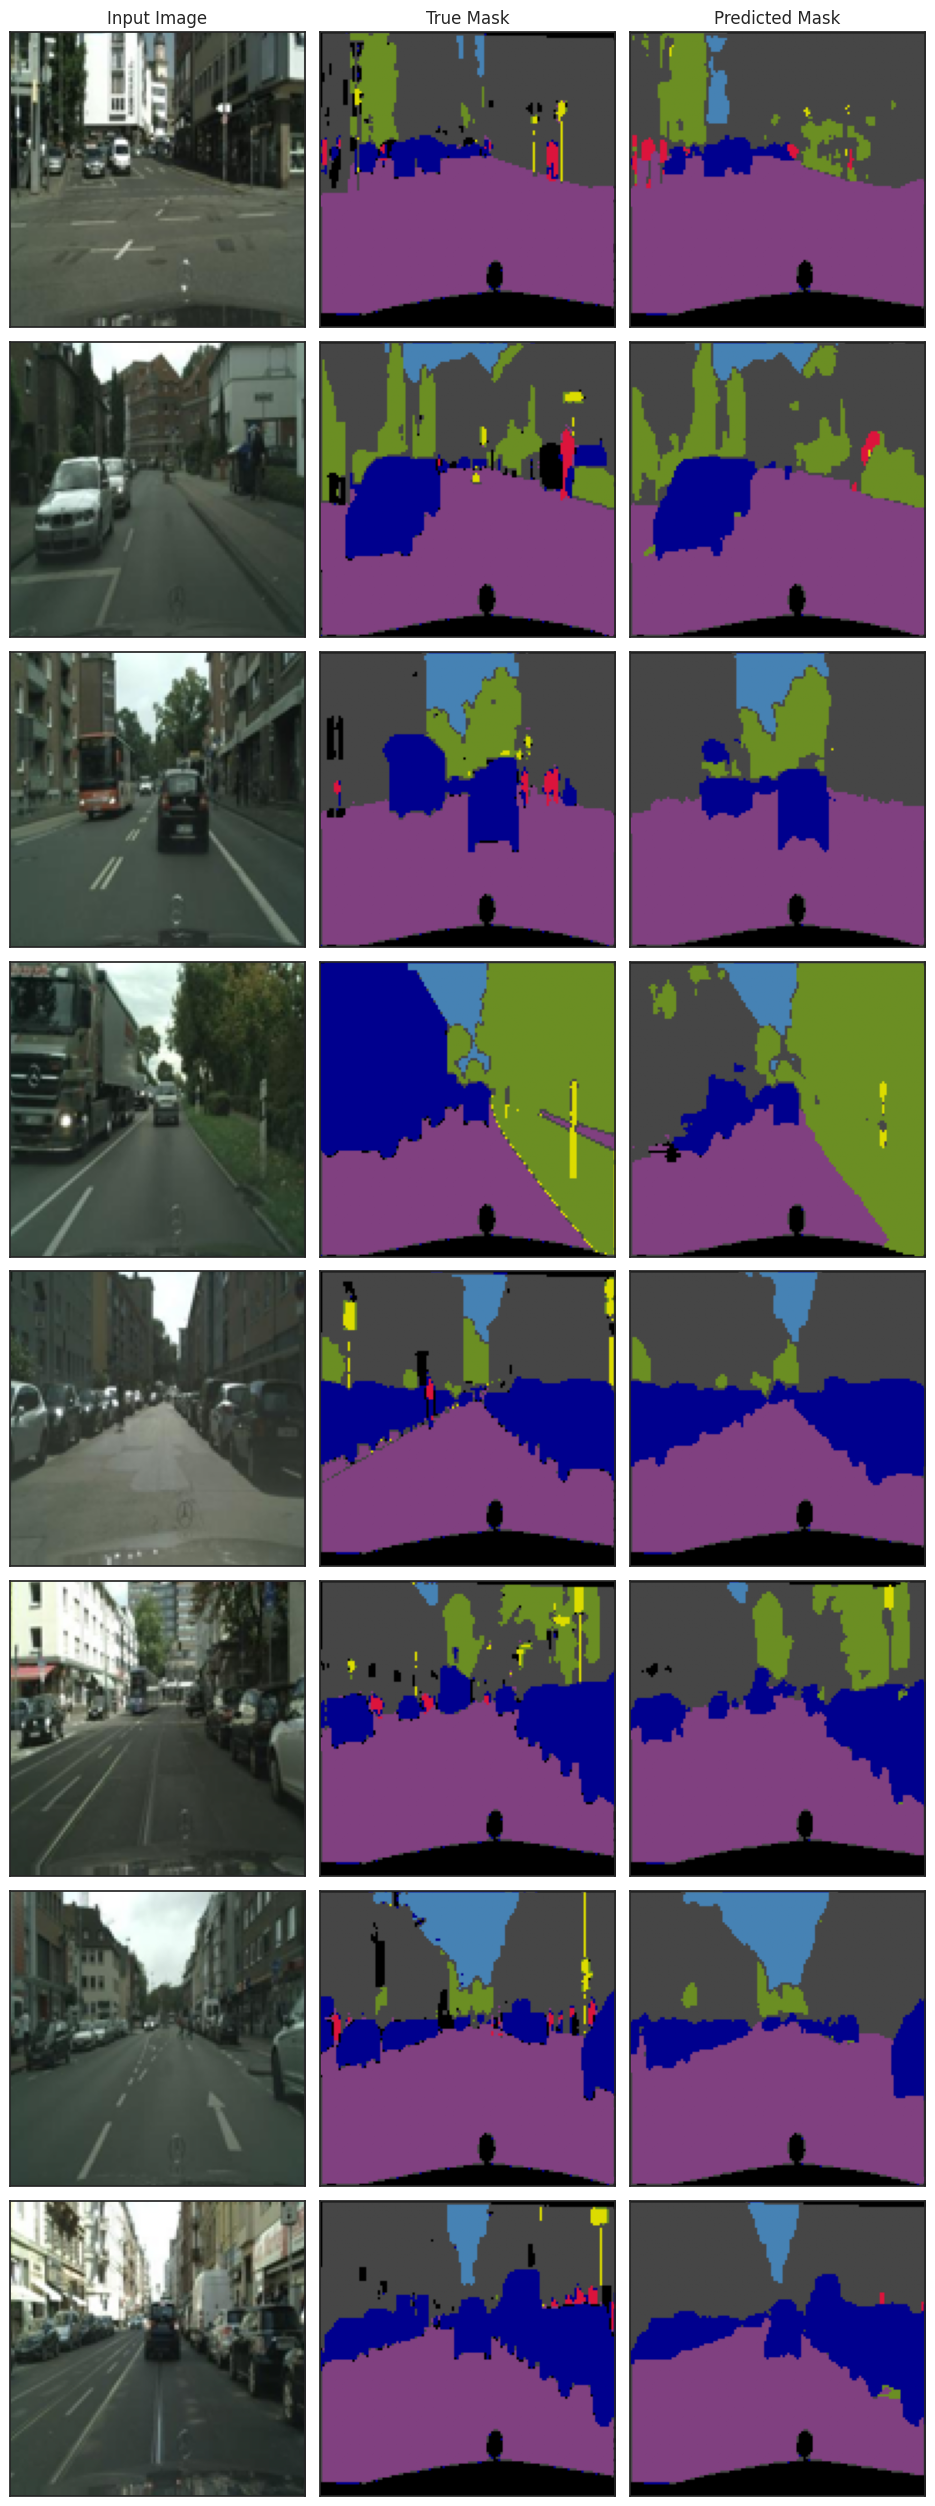

In [166]:
batch = next(iter(val_dataloader))
predictions = model_nested(batch[0].to(device))
show_inference(batch, predictions)

##Attention Unet

In [52]:
class ConvBlockAttention(nn.Module):
    """Simplified convolution block with a single Conv layer, BatchNorm, and ReLU."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlockAttention(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x

class AttentionBlock(nn.Module):
    """Simplified Attention Gate."""
    def __init__(self, f_g, f_l, out_channels):
        super(AttentionBlock, self).__init__()
        self.conv_g = nn.Conv2d(f_g, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_x = nn.Conv2d(f_l, out_channels, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(out_channels, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        psi = self.sigmoid(self.psi(F.relu(self.conv_g(g) + self.conv_x(x))))
        return x * psi

class UpScale(nn.Module):
    """Upscaling with a single ConvBlock and an optional Attention Gate."""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = ConvBlockAttention(in_channels, out_channels)
        self.attention = AttentionBlock(f_g=in_channels // 2, f_l=out_channels, out_channels=out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x2 = self.attention(x1, x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class AttentionUnetLite(nn.Module):
    """Lightweight Attention U-Net with reduced depth and complexity."""
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(AttentionUnetLite, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = ConvBlockAttention(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)

        factor = 2 if bilinear else 1
        self.down3 = DownScale(4*start, 8*start // factor)

        self.up1 = UpScale(8*start, 4*start // factor, bilinear)
        self.up2 = UpScale(4*start, 2*start, bilinear)
        self.up3 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


In [53]:
summary(AttentionUnetLite(3, number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUnetLite                        [8, 8, 128, 128]          --
├─ConvBlockAttention: 1-1                [8, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [8, 32, 128, 128]         64
│    └─ReLU: 2-3                         [8, 32, 128, 128]         --
├─DownScale: 1-2                         [8, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [8, 32, 64, 64]           --
│    └─ConvBlockAttention: 2-5           [8, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [8, 64, 64, 64]           18,432
│    │    └─BatchNorm2d: 3-2             [8, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [8, 64, 64, 64]           --
├─DownScale: 1-3                         [8, 128, 32, 32]          --
│    └─MaxPool2d: 2-6                    [8, 64, 32, 32]           --
│    └─Co

In [ ]:
model = AttentionUnetLite(3, number_of_classes)
model = model.to(device)
AttentionUnet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS,with_dice=True, with_iou=True)

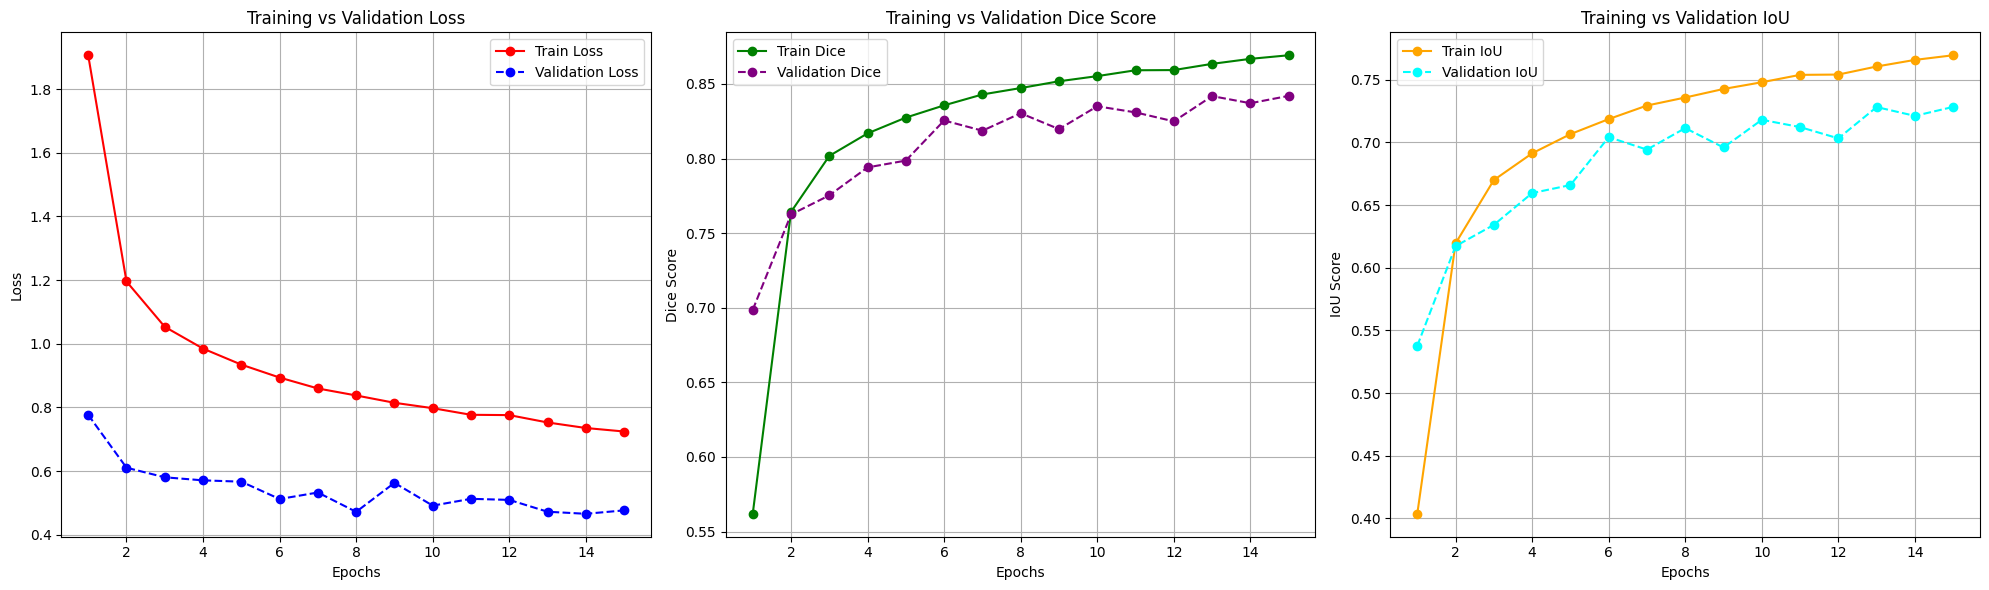

In [57]:
plot_training_progress(AttentionUnet_training_val_summary)

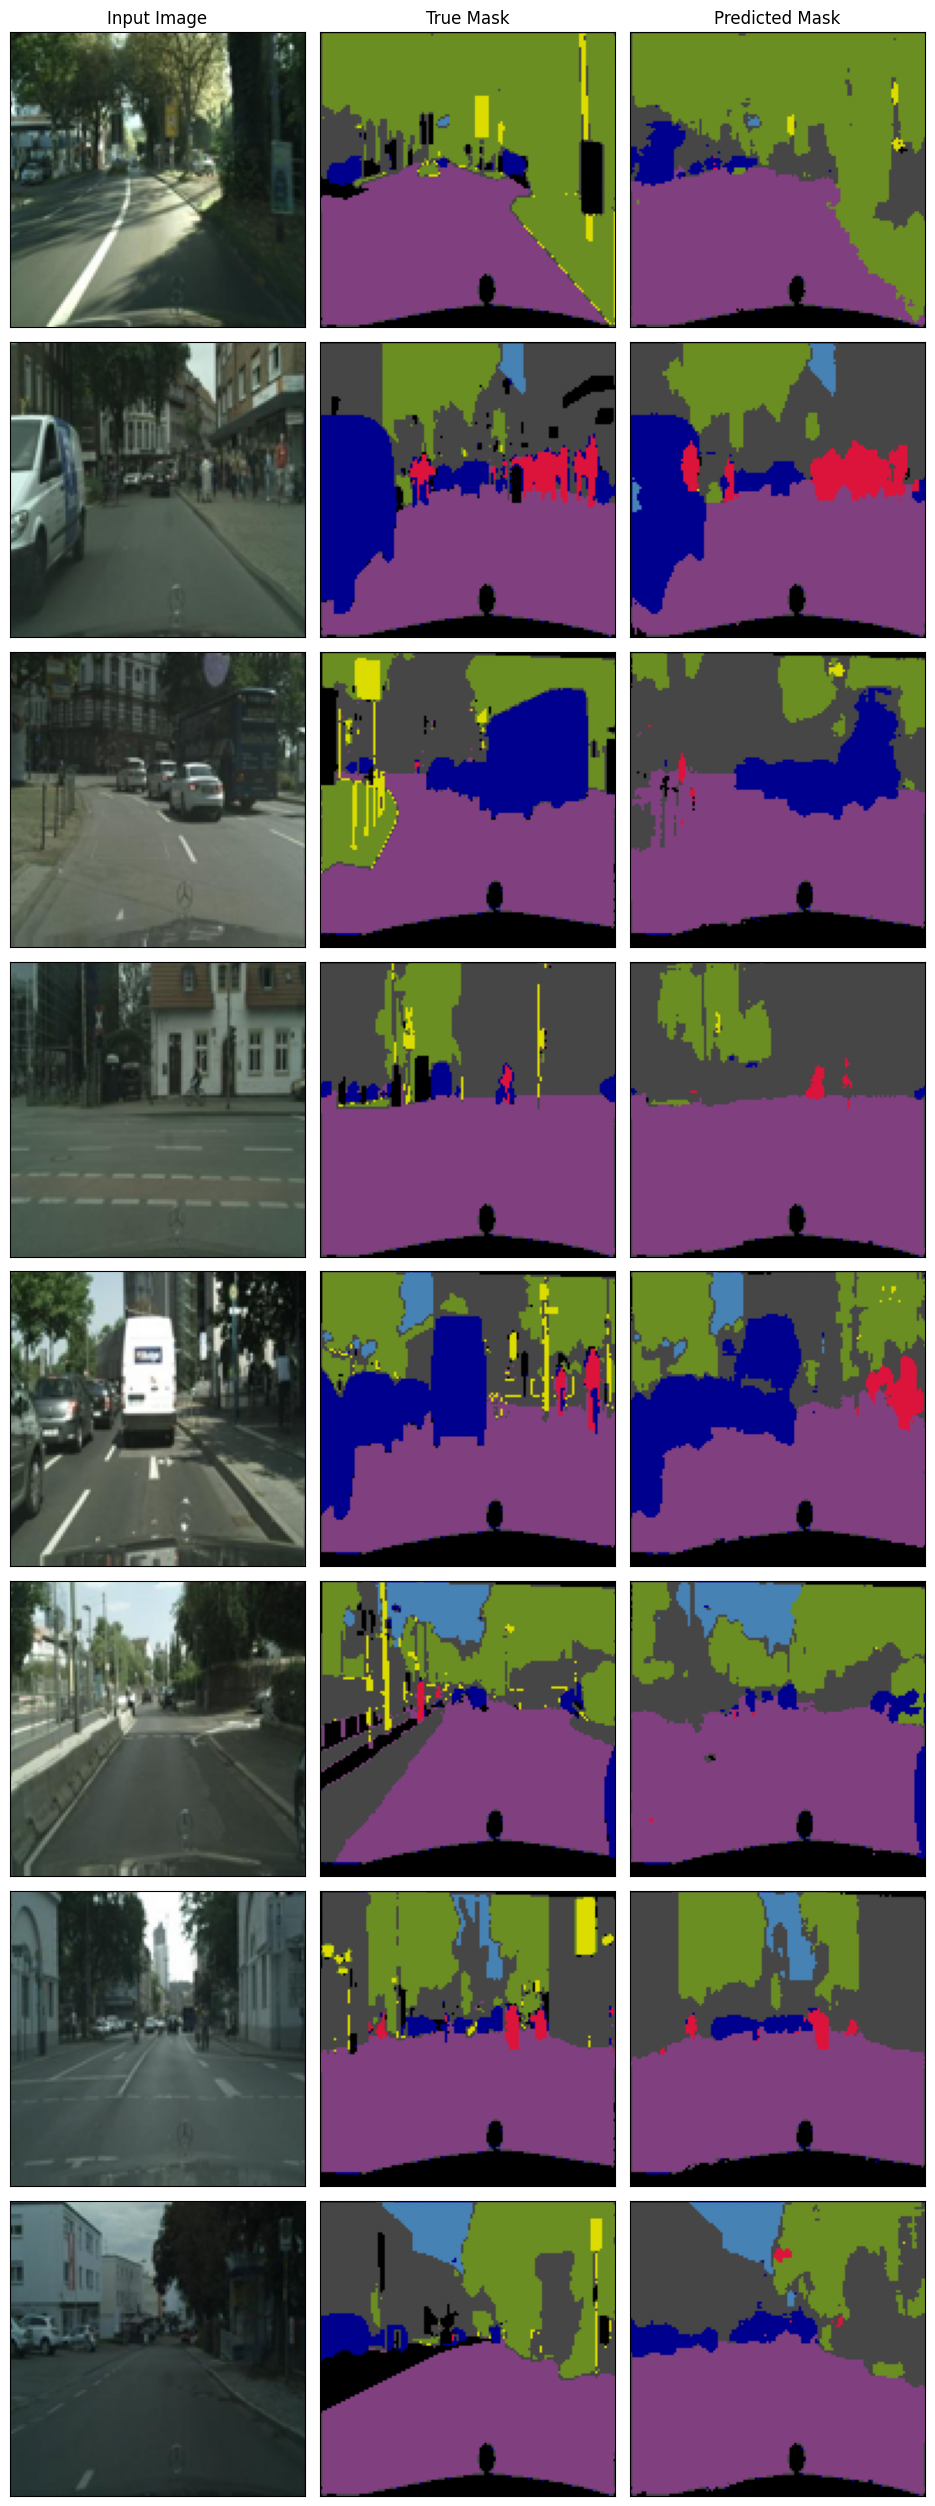

In [58]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)